<a href="https://colab.research.google.com/github/HaykalRamadhan/forecasting/blob/main/UP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Forecasting Per Monthly

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load data
ct = pd.read_csv('/content/drive/MyDrive/UP/sample_data/Monthly_Sales_Summary.csv')

In [4]:
# Convert 'Transaksi' (string YYYY-MM) to numeric value (year + month/12)
ct[['Year', 'Month']] = ct['Transaksi'].str.split('-', expand=True)
ct['Year'] = ct['Year'].astype(int)
ct['Month'] = ct['Month'].astype(int)
ct['Transaksi_Numeric'] = ct['Year'] + (ct['Month'] / 12)

In [5]:
# Sort by numeric
ct = ct.sort_values(by="Transaksi_Numeric")

In [6]:
# Define X and Y in array
x = np.array(ct["Transaksi_Numeric"])
y = np.array(ct["Total"])

print(x)
print(y)

[2023.91666667 2024.         2024.08333333 2024.16666667 2024.25
 2024.33333333 2024.41666667 2024.5        2024.58333333 2024.66666667
 2024.75       2024.83333333 2024.91666667 2025.         2025.08333333
 2025.16666667]
[  108396.56  2686599.    8708216.79 11582148.11 11881916.18 14772076.59
 14116645.83 15660415.44 14234010.85 15790109.88 13163186.6  14519152.52
 15343173.46 14234703.68 13867183.9  11788947.78]


In [7]:
# Function to compute R2 manually
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    r2_score = 1 - (sse / tss)
    return r2_score

In [8]:
# Future prediction points (next 3 months)
last_year = ct['Year'].max()
last_month = ct[ct['Year'] == last_year]['Month'].max()
future_dates = []
for i in range(1, 4):
    new_month = last_month + i
    new_year = last_year
    if new_month > 12:
        new_year += 1
        new_month -= 12
    future_numeric = new_year + (new_month / 12)
    future_dates.append(future_numeric)
x2 = np.array(future_dates)


--- Polynomial Regression Degree 2 ---
R2 Score: 0.8993
Future Predictions:
Transaksi 2025-03: Predicted Total = 9277098.75
Transaksi 2025-04: Predicted Total = 7043623.98
Transaksi 2025-05: Predicted Total = 4491853.56


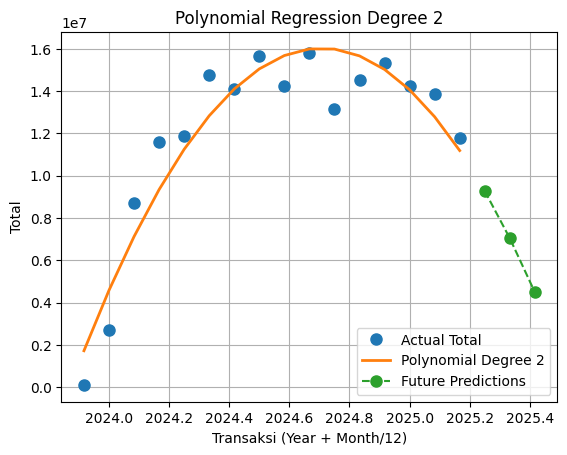


--- Polynomial Regression Degree 3 ---
R2 Score: 0.9493
Future Predictions:
Transaksi 2025-03: Predicted Total = 13084896.00
Transaksi 2025-04: Predicted Total = 13539424.00
Transaksi 2025-05: Predicted Total = 14422144.00


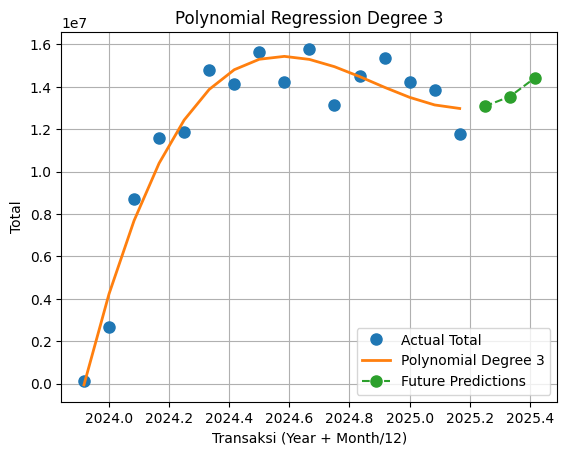


--- Polynomial Regression Degree 4 ---
R2 Score: 0.9493
Future Predictions:
Transaksi 2025-03: Predicted Total = 13085472.00
Transaksi 2025-04: Predicted Total = 13540448.00
Transaksi 2025-05: Predicted Total = 14424096.00


<ipython-input-9-8209e024abb8>:5: RankWarning: Polyfit may be poorly conditioned
  AB = np.polyfit(x, y, degree)


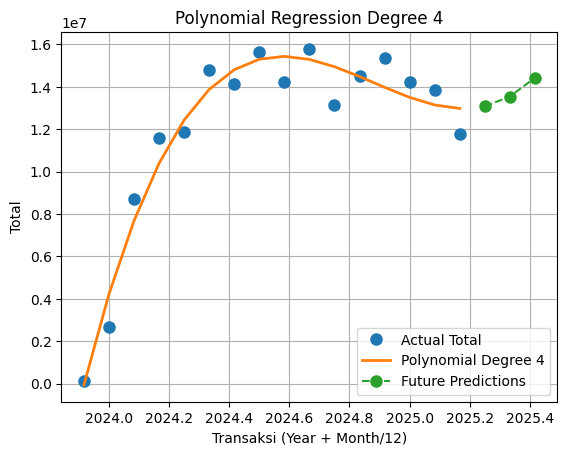

In [9]:
# Polynomial regression degrees 2, 3, 4
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")

    AB = np.polyfit(x, y, degree)
    func = np.poly1d(AB)

    y_p = func(x)   # prediction for existing points
    y_p2 = func(x2) # prediction for future points

    # Compute R2
    r2 = compute_r2(y, y_p)
    print(f"R2 Score: {r2:.4f}")
    print("Future Predictions:")
    for trans, pred in zip(x2, y_p2):
        year = int(trans)
        month = int(round((trans - year) * 12))
        if month == 0:
            month = 12
            year -= 1
        print(f"Transaksi {year}-{str(month).zfill(2)}: Predicted Total = {pred:.2f}")

    plt.plot(x, y, linestyle="none", marker='o', markersize=8, label='Actual Total')
    plt.plot(x, y_p, linewidth=2, label=f'Polynomial Degree {degree}')
    plt.plot(x2, y_p2, marker='o', linestyle='dashed', markersize=8, label='Future Predictions')
    plt.xlabel('Transaksi (Year + Month/12)')
    plt.ylabel('Total')
    plt.title(f'Polynomial Regression Degree {degree}')
    plt.legend()
    plt.grid(True)
    plt.show()


# Forecasting Per Weekly

<ipython-input-39-31c915541461>:14: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)



--- Polynomial Regression Degree 2 ---
R² Score: 0.2866
Prediksi 3 minggu ke depan:
Minggu 2025-14: Rp 1.546.411
Minggu 2025-15: Rp 1.739.451
Minggu 2025-16: Rp 1.949.942


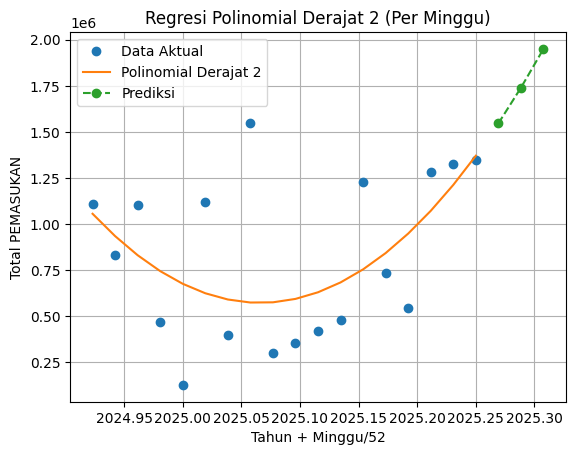


--- Polynomial Regression Degree 3 ---
R² Score: 0.2891
Prediksi 3 minggu ke depan:
Minggu 2025-14: Rp 1.625.216
Minggu 2025-15: Rp 1.868.480
Minggu 2025-16: Rp 2.141.536


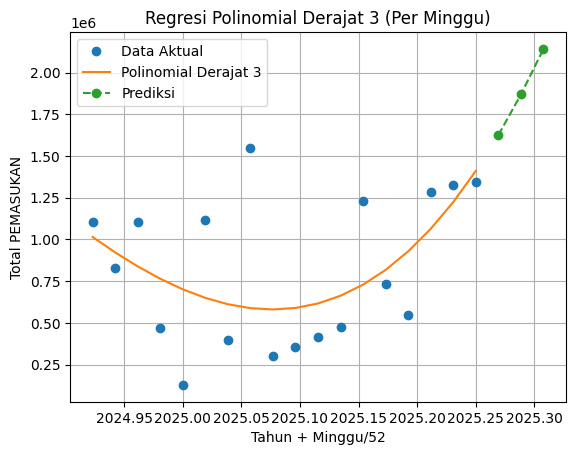


--- Polynomial Regression Degree 4 ---
R² Score: 0.2891
Prediksi 3 minggu ke depan:
Minggu 2025-14: Rp 1.625.536
Minggu 2025-15: Rp 1.868.496
Minggu 2025-16: Rp 2.141.344


<ipython-input-39-31c915541461>:55: RankWarning: Polyfit may be poorly conditioned
  AB = np.polyfit(x, y, degree)


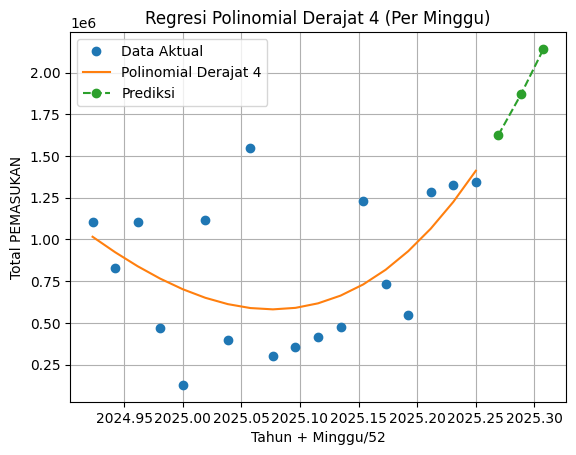

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV
file_path = '/content/drive/MyDrive/UP/sample_data/rekapitulasi_saint_coffee_4_bulan.csv'
ct = pd.read_csv(file_path)

# Bersihkan dan standar kolom
ct.columns = ct.columns.str.strip().str.upper()
ct = ct.rename(columns={'TANGGAL': 'Tanggal', 'PEMASUKKAN': 'PEMASUKAN'})

# Konversi tanggal ke datetime
ct['Tanggal'] = pd.to_datetime(ct['Tanggal'], dayfirst=True)

# Konversi PEMASUKAN ke angka (hapus titik, koma, dan karakter non-angka jika perlu)
ct['PEMASUKAN'] = ct['PEMASUKAN'].replace('[^0-9]', '', regex=True).astype(float)

# Ambil tahun dan minggu dari tanggal
ct['Year'] = ct['Tanggal'].dt.isocalendar().year
ct['Week'] = ct['Tanggal'].dt.isocalendar().week

# Hitung total mingguan
weekly = ct.groupby(['Year', 'Week']).agg({'PEMASUKAN': 'sum'}).reset_index()
weekly['Transaksi_Numeric'] = weekly['Year'] + (weekly['Week'] / 52)

# Siapkan X dan Y
x = np.array(weekly['Transaksi_Numeric'])
y = np.array(weekly['PEMASUKAN'])

# Fungsi untuk menghitung R²
def compute_r2(y_true, y_predict):
    sse = sum((y_true - y_predict) ** 2)
    tss = (len(y_true) - 1) * np.var(y_true, ddof=1)
    return 1 - (sse / tss)

# Prediksi 3 minggu ke depan
last_year = weekly['Year'].max()
last_week = weekly[weekly['Year'] == last_year]['Week'].max()

future_dates = []
for i in range(1, 4):
    new_week = last_week + i
    new_year = last_year
    if new_week > 52:
        new_year += 1
        new_week -= 52
    future_numeric = new_year + (new_week / 52)
    future_dates.append(future_numeric)
x2 = np.array(future_dates)

# Forecast dengan polynomial regression (derajat 2, 3, 4)
for degree in [2, 3, 4]:
    print(f"\n--- Polynomial Regression Degree {degree} ---")
    AB = np.polyfit(x, y, degree)
    func = np.poly1d(AB)

    y_p = func(x)
    y_p2 = func(x2)

    r2 = compute_r2(y, y_p)
    print(f"R² Score: {r2:.4f}")
    print("Prediksi 3 minggu ke depan:")
    for trans, pred in zip(x2, y_p2):
        year = int(trans)
        week = int(round((trans - year) * 52))
        if week == 0:
            week = 52
            year -= 1
        print(f"Minggu {year}-{str(week).zfill(2)}: Rp {int(pred):,}".replace(",", "."))

    # Plot
    plt.plot(x, y, linestyle="none", marker='o', label='Data Aktual')
    plt.plot(x, y_p, label=f'Polinomial Derajat {degree}')
    plt.plot(x2, y_p2, marker='o', linestyle='dashed', label='Prediksi')
    plt.xlabel('Tahun + Minggu/52')
    plt.ylabel('Total PEMASUKAN')
    plt.title(f'Regresi Polinomial Derajat {degree} (Per Minggu)')
    plt.legend()
    plt.grid(True)
    plt.show()
